In [13]:
# Setup environment to load precomputed embeddings
import os, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to sys.path
notebook_dir = Path().resolve()
project_dir = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
sys.path.insert(0, str(project_dir))

# Set paths
data_dir = project_dir / 'data'
embeddings_dir = data_dir / 'embeddings'
analysis_dir = data_dir / 'analysis' / 'locus_embeddings'

def load_embeddings(locus, class_type):
    embeddings_file = analysis_dir / class_type / 'embeddings' / f"hla_{locus}_embeddings.pkl"
    if not embeddings_file.exists():
        print(f"File {embeddings_file} not found. Run the analysis script first.")
        return None
    with open(embeddings_file, 'rb') as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings for HLA-{locus}")
    return embeddings


# B Locus Clustering Analysis

This notebook encodes the alleles at the B locus, performs clustering on the embeddings, and compares the cluster labels to the serological groupings (e.g. B*01, B*02, etc.).

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Attempt to load precomputed embeddings for B locus
embeddings = load_embeddings('B', 'class1')
if embeddings is None:
    # Precomputed embeddings not found; fall back to encoding sequences
    allele_file = 'data/raw/fasta/B_prot.fasta'
    with open(allele_file, 'r') as f:
        sequences = f.read().splitlines()
    from src.models.protbert import encode_sequences  # Ensure this function exists
    embeddings = encode_sequences(sequences)
if embeddings is not None and embeddings:
    # Show some basic stats
    allele = list(embeddings.keys())[0]
    embedding = embeddings[allele]
    print(f"Sample allele: {allele}")
    print(f"Embedding shape: {embedding.shape}")
    print(f"First 5 dimensions: {embedding[:5]}")

Loaded 6526 embeddings for HLA-B
Sample allele: B*07:02
Embedding shape: (1024,)
First 5 dimensions: [ 0.22962688  0.05856375 -0.00037082 -0.17931563  0.10208432]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


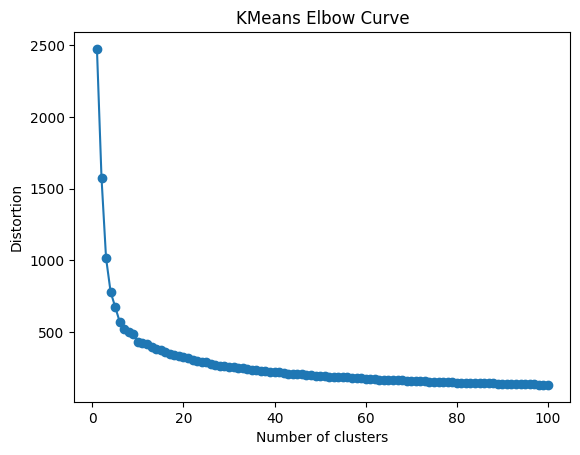

Optimal number of clusters: 100


In [ ]:
# Cluster the embeddings using KMeans, find the best number of classes automatically,  embeddings at the moment is a dictionary
# with the allele as key and the embedding as value
def cluster_embeddings(embeddings, max_clusters=36):
    # Convert embeddings to array
    X = np.array(list(embeddings.values()))
    # Find optimal number of clusters
    distortions = []
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
        distortions.append(kmeans.inertia_)
    # Plot elbow curve
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('KMeans Elbow Curve')
    plt.show()
    # Fit KMeans with optimal number of clusters
    n_clusters = np.argmin(distortions) + 1
    print(f"Optimal number of clusters: {n_clusters}")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    return kmeans

kmeans = cluster_embeddings(embeddings)



[27 27 27 ... 94 95 95]
dict_keys(['B*07:02', 'B*07:03', 'B*07:04', 'B*07:05', 'B*07:06', 'B*07:07', 'B*07:08', 'B*07:09', 'B*07:10', 'B*07:11', 'B*07:12', 'B*07:13', 'B*07:14', 'B*07:15', 'B*07:16', 'B*07:17', 'B*07:18', 'B*07:19', 'B*07:20', 'B*07:21', 'B*07:22', 'B*07:23', 'B*07:24', 'B*07:25', 'B*07:26', 'B*07:27', 'B*07:28', 'B*07:29', 'B*07:30', 'B*07:31', 'B*07:32', 'B*07:33', 'B*07:34', 'B*07:35', 'B*07:36', 'B*07:37', 'B*07:38', 'B*07:39', 'B*07:40', 'B*07:41', 'B*07:42', 'B*07:43', 'B*07:44N', 'B*07:45', 'B*07:46', 'B*07:47', 'B*07:48', 'B*07:49N', 'B*07:50', 'B*07:51', 'B*07:52', 'B*07:53', 'B*07:54', 'B*07:55', 'B*07:56', 'B*07:57', 'B*07:58', 'B*07:59', 'B*07:60', 'B*07:61', 'B*07:62', 'B*07:63', 'B*07:64', 'B*07:65', 'B*07:66', 'B*07:67N', 'B*07:68', 'B*07:69', 'B*07:70', 'B*07:71', 'B*07:72', 'B*07:73', 'B*07:74', 'B*07:75', 'B*07:76', 'B*07:77', 'B*07:78', 'B*07:79', 'B*07:80', 'B*07:81', 'B*07:82', 'B*07:83', 'B*07:84', 'B*07:85', 'B*07:86', 'B*07:87', 'B*07:88', 'B*07

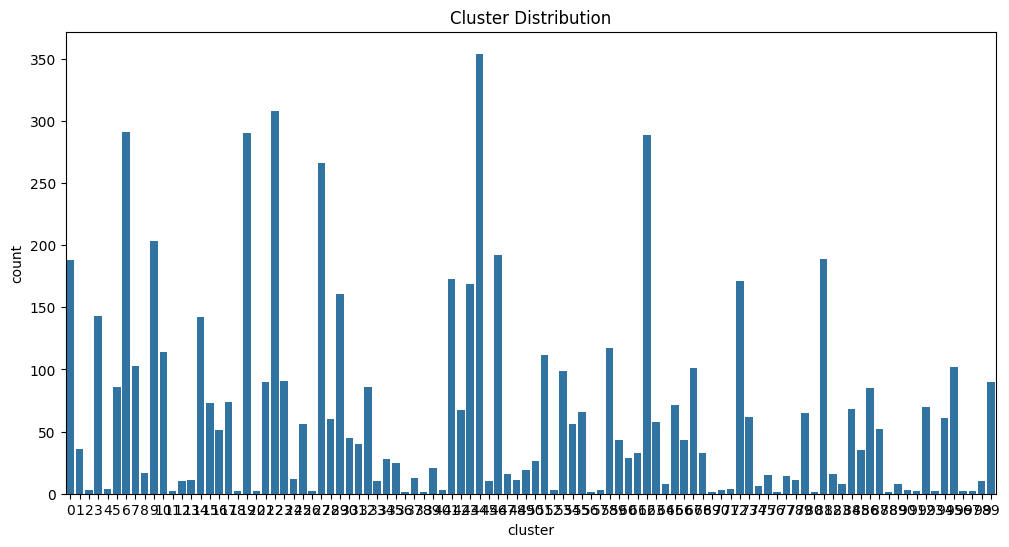

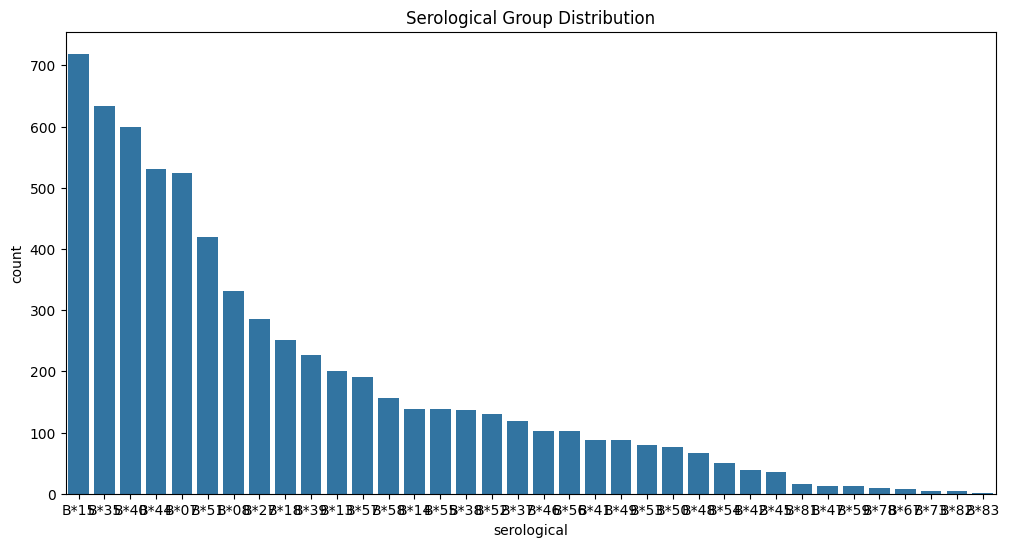

In [33]:
# Compare clusters to serological groups
all_alleles= embeddings.keys()
# Load serological name (name of allele upto first ':')
serological_mapping = all_alleles
serological_mapping = [allele.split(':')[0] for allele in all_alleles]
# Get cluster labels
cluster_labels = kmeans.labels_
print(cluster_labels)
print(all_alleles)
print(serological_mapping)

# Create a DataFrame with allele, serological group, and cluster label
df = pd.DataFrame({'allele': all_alleles, 'serological': serological_mapping, 'cluster': cluster_labels})
df = df.sort_values('cluster')

# Plot cluster distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='cluster', data=df)
plt.title('Cluster Distribution')
plt.show()

# Plot serological group distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='serological', data=df, order=df['serological'].value_counts().index)
plt.title('Serological Group Distribution')
plt.show()
